# NMF

In [59]:
import networkx as nx
import numpy as np
from sklearn.decomposition import NMF
from scipy.spatial import distance

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['beta']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [60]:
#G = nx.watts_strogatz_graph(2000, 10, 0.1, seed=42)
G = nx.barabasi_albert_graph(200, m=2)

In [61]:
A = nx.to_numpy_matrix(G)

In [62]:
def overlap_generator(G):
    """
    Function to generate a neighbourhood overlap matrix (second-order proximity matrix).
    :param G: Graph object.
    :return laps: Overlap matrix.
    """
    print("Second order proximity calculation.\n")
    degrees = nx.degree(G)
    sets = {node:set(G.neighbors(node)) for node in nx.nodes(G)}
    laps = np.array([[float(len(sets[node_1].intersection(sets[node_2])))/(float(degrees[node_1]*degrees[node_2])**0.5) if node_1 != node_2 else 0.0 for node_1 in nx.nodes(G)] for node_2 in nx.nodes(G)],dtype = np.float64)
    return laps

In [68]:
%%time
eta = 0.5
beta = 0.
S_0 = overlap_generator(G)
R = np.random.rand(G.number_of_nodes(), G.number_of_nodes())

S = eta*S_0 + A + beta*R
model = NMF(n_components=10, init='random', random_state=0)
W = model.fit_transform(S)
H = model.components_

Second order proximity calculation.

CPU times: user 168 ms, sys: 9.81 ms, total: 177 ms
Wall time: 108 ms


In [69]:
EPSILON = 1E-5
METRIC_NAMES = ['ratio', 'sub', 'like']
def homophily_metrics(similarity_edges, similarity_nonedges):
    return {
        'ratio': np.mean(similarity_edges) / np.mean(similarity_nonedges),
        'sub': np.mean(similarity_edges) - np.mean(similarity_nonedges),
        'like': np.sum(np.log(similarity_edges + EPSILON)) + np.sum(np.log(1 - similarity_nonedges + EPSILON)) ,
    }

In [70]:
# similarity between connected nodes
def sim_in(G):
    sims = []
    for i in G.nodes:
        for j in list(G.neighbors(i)):
            #print(G.nodes[i]['interests'], emb[i])
            sims.append(1 - distance.cosine(G.nodes[i]['interests'], G.nodes[j]['interests']))
    return np.mean(sims)

def select_notedge(G):
    v1 = np.random.choice(G.nodes())
    v2 = np.random.choice(G.nodes())

    while (v1,v2) in G.edges or v1==v2:
        v1 = np.random.choice(G.nodes())
        v2 = np.random.choice(G.nodes())
    return v1, v2
#     n = nx.number_of_nodes(G)
#     while True:
#         a, b = np.random.randint(0, n, size=2)
#         if (a, b) not in G.edges:
#             return a, b

# similarity between disconnected nodes
def sim_out(G, samples):
    sims_out = []
    for c in range(samples):
        i, j = select_notedge(G)
        sims_out.append(1 - distance.cosine(G.nodes[i]['interests'], G.nodes[j]['interests']))
    return np.mean(sims_out)

def homophily(G):
    return sim_in(G) / sim_out(G, 5000)

In [71]:
def evaluate_metrics(graph, emb):
    '''
    Returns the three metrics for si and so defined in homophily_metrics function
    '''
    # building the graph
    for i in graph.nodes:
        graph.nodes[i]['interests'] = emb[int(i)]
        
    # calculating si and so
    output = {}
    si = sim_in(graph)
    so = sim_out(graph, 5000)
    output['si'] = round(si, 4)
    output['so'] = round(so, 4)
    for name, metric in homophily_metrics(si, so).items():
        output[name] = round(metric, 4)

    return output

In [72]:
evaluate_metrics(G, W)

{'like': -0.6483, 'ratio': 3.1166, 'si': 0.6647, 'so': 0.2133, 'sub': 0.4514}

In [11]:
def draw_emb(emb, title='', row=False):
    '''
    NB only for 2d embeddings
    params: dict of parameters for title
    '''
    nodes = [_ for _ in range(len(emb))]
    x_plot = [emb[_, 0] for _ in range(len(emb))]
    y_plot = [emb[_, 1] for _ in range(len(emb))]
    if row:
        row.scatter(x_plot, y_plot, linewidths=10)
        row.set_title(title)
    if not row:
        fig, ax = plt.subplots()
        ax.scatter(x_plot, y_plot, linewidths=5)
        for _ in range(len(nodes)):
            ax.annotate(nodes[_], (x_plot[_], y_plot[_]))
        ax.set_title(title)

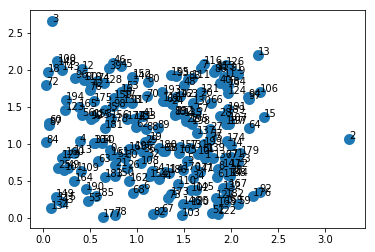

In [12]:
R_fin = np.random.rand(G.number_of_nodes(), 2)

draw_emb(W+2*R_fin)

In [73]:
model = NMF(n_components=10, init='random', random_state=0)
W = model.fit_transform(A)
H = model.components_

In [74]:
evaluate_metrics(G, W)

{'like': -1.9892, 'ratio': 0.8328, 'si': 0.1725, 'so': 0.2072, 'sub': -0.0346}